In [1]:
from urllib.request import urlretrieve
import os
import numpy as np
import matplotlib.pyplot as pyplot
%matplotlib inline  

URM_file = open(r"C:\Users\aless\PYTHON_NOTEBOOKS\RECOMMENDER_CHALLENGE\data_train.csv", 'r')

def rowSplit (rowString):
    
    split = rowString.split(",")
    split[2] = split[2].replace("\n","")
    
    split[0] = int(split[0])#userID = row o forse row+1?? Dipende da come pensiamo id
    split[1] = int(split[1])#itemId =column
    split[2] = int(float(split[2]))#rating IMPLICIT
    result = tuple(split)
    
    return result



URM_file.seek(0)
URM_tuples = []
URM_file.readline()#questa è importante di cristo c'è riga di introduzione
for line in URM_file:
    URM_tuples.append(rowSplit (line))


#ora devo costruire saggiamente la matrice


data = np.array(URM_tuples)
#print("Numero di rating:"+str(data.shape[0]))
#crea URM
result = np.zeros((data[:,0].max()+1, data[:,1].max()+1), dtype=int)
result[data[:,0], data[:,1]] = data[:,2] 

userList=set(data[:,0])#significa tutte le righe considerando solo la colonna 1
itemList=set(data[:,1])
ratingList=data.shape[0]

print("Num Utenti: "+str(len(userList)))
print("Num Items: "+str(len(itemList)))
print("Num Ratings: "+str(ratingList)) #sarà righe-1 di itnestazione
print(result.shape)#forma della matrice 


import scipy.sparse as sps

URM_all = sps.coo_matrix(result)
URM_all = URM_all.tocsr()

Num Utenti: 7947
Num Items: 24896
Num Ratings: 113268
(7947, 25975)


In [2]:

from Notebooks_utils.data_splitter import train_test_holdout
from Notebooks_utils.evaluation_function import evaluate_algorithm
from Base.Similarity.Compute_Similarity_Python import Compute_Similarity_Python

URM_train, URM_test = train_test_holdout(URM_all, train_perc = 0.8)#sono traine test locali,aka train e valiation
#-----------------------------------------------------------------------
#-------------------------STUFF-----------------------------------------
#-----------------------------------------------------------------------
class ItemCFKNNRecommender(object):
    
    def __init__(self, URM):
        self.URM = URM
        
            
    def fit(self, topK=50, shrink=100, normalize=True, similarity="cosine"):
        
        similarity_object = Compute_Similarity_Python(self.URM, shrink=shrink, 
                                                  topK=topK, normalize=normalize, 
                                                  similarity = similarity)
        
        self.W_sparse = similarity_object.compute_similarity()

        
    def recommend(self, user_id, at=None, exclude_seen=True):
        # compute the scores using the dot product
        user_profile = self.URM[user_id]
        scores = user_profile.dot(self.W_sparse).toarray().ravel()

        if exclude_seen:
            scores = self.filter_seen(user_id, scores)

        # rank items
        ranking = scores.argsort()[::-1]
            
        return ranking[:at]
    
    
    def filter_seen(self, user_id, scores):

        start_pos = self.URM.indptr[user_id]
        end_pos = self.URM.indptr[user_id+1]

        user_profile = self.URM.indices[start_pos:end_pos]
        
        scores[user_profile] = -np.inf

        return scores
#----------------------------------------------------------------    
    
recommender = ItemCFKNNRecommender(URM_train)
recommender.fit(shrink=0.0, topK=50)


print("La velocità con cui lavoro è:")

import time

n_users_to_test = len(set(userList))#setto numero di users x cui faccio reccomendation

start_time = time.time()

for user_id in range(n_users_to_test):
    recommender.recommend(user_id, at=5)#at è numero items che raccomando!
    
end_time = time.time()

print(" {:.2f} usr/sec".format(n_users_to_test/(end_time-start_time)))



Similarity column 25975 ( 100 % ), 2665.35 column/sec, elapsed time 0.16 min
La velocità con cui lavoro è:
 257.30 usr/sec


## Parameters tuning

PARAMETER TUNING
Similarity column 25975 ( 100 % ), 2947.92 column/sec, elapsed time 0.15 min
Evaluated user 0 of 7947
Recommender performance is: Precision = 0.0372, Recall = 0.0633, MAP = 0.0433


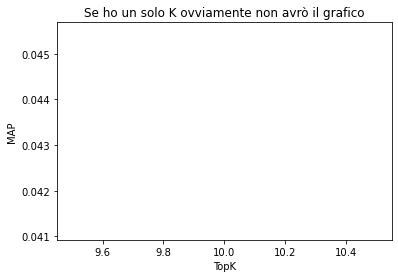

In [3]:
print("PARAMETER TUNING")
#x_tick = [5,10,15,50,100,500] #10 best
x_tick = [10] #10 best
MAP_per_k = []

for topK in x_tick:
    
    recommender = ItemCFKNNRecommender(URM_train)
    recommender.fit(shrink=100, topK=topK)#shrink a 100 negli shrink è il best off
    
    result_dict = evaluate_algorithm(URM_test, recommender)
    MAP_per_k.append(result_dict["MAP"])
    
pyplot.plot(x_tick, MAP_per_k)
pyplot.ylabel('MAP')
pyplot.xlabel('TopK')
pyplot.title("Se ho un solo K ovviamente non avrò il grafico")
pyplot.show()


Similarity column 25975 ( 100 % ), 3045.73 column/sec, elapsed time 0.14 min
Evaluated user 0 of 7947
Recommender performance is: Precision = 0.0368, Recall = 0.0633, MAP = 0.0431


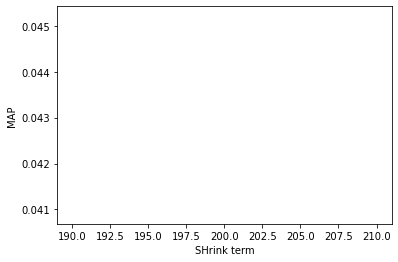

In [4]:
#x_tick = [100, 200, 500,1000,2000] #ha un botto effetto pare, 200 è il top
x_tick = [200]
MAP_per_shrinkage = []

for shrink in x_tick:
    
    recommender =  ItemCFKNNRecommender(URM_train)
    recommender.fit(shrink=shrink, topK=10)
    
    result_dict = evaluate_algorithm(URM_test, recommender)
    MAP_per_shrinkage.append(result_dict["MAP"])
    
pyplot.plot(x_tick, MAP_per_shrinkage)
pyplot.ylabel('MAP')
pyplot.xlabel('SHrink term')
pyplot.show()   